In [1]:
import numpy
from numpy import ndarray as Array
from typing import Tuple, Dict, List, Generator

from objects import NormalModel, TransitionDensity
from utils import transmutator, rand_obs, rand_nnd
import matplotlib.pyplot as plt

In [43]:
n: "int" = 1
m: "int" = 1
p: "int" = 3

n0: "NormalModel" = rand_obs((p,n))
n0.covariance = rand_nnd(p, 1)

b_e = numpy.zeros((p, n)) # p by n
b_p = numpy.zeros((m, n)) # m by n

a_e = numpy.array([[1,1,1],[0,1,0],[0,0,1]]) # p by p
a_p = numpy.array([[1,0,0]]) # m by p

v_e = numpy.eye(p)
v_p = numpy.eye(m)


tp: "TransitionDensity" = TransitionDensity(b_p, a_p, v_p)


te: "TransitionDensity" = TransitionDensity(b_e, a_e, v_e)

In [44]:
period: "int" = 100

filtered_states: "List[NormalModel]" = [n0]
evolved_states: "List[NormalModel]" = list()
smoothed_states: "List[NormalModel]" = list()

filtered_spaces: "List[NormalModel]" = list()
evolved_spaces: "List[NormalModel]" = list()
observed_spaces: "List[NormalModel]" = list()
smoothed_spaces: "List[NormalModel]" = list()

smoothers: "List[TransitionDensity]" = list()

for _ in range(period):

    nf1 = filtered_states[-1]
    te.weights[0,2] = 1 #nf1.mean[1,0]
    ne1, ts = transmutator(nf1, te)
    ne2, tf = transmutator(ne1, tp)
    no2 = rand_obs((m,n))
    nf1 = transmutator(no2, tf, True)
    nf2 = transmutator(nf1, tp, True)

    smoothers.append(ts)
    evolved_states.append(ne1)
    evolved_spaces.append(ne2)
    observed_spaces.append(no2)
    filtered_states.append(nf1)
    filtered_spaces.append(nf2)


    




In [45]:
def model_extract(model_list: "List[NormalModel]") -> "Generator[float]":
    for model in model_list:
        yield model.mean.item()

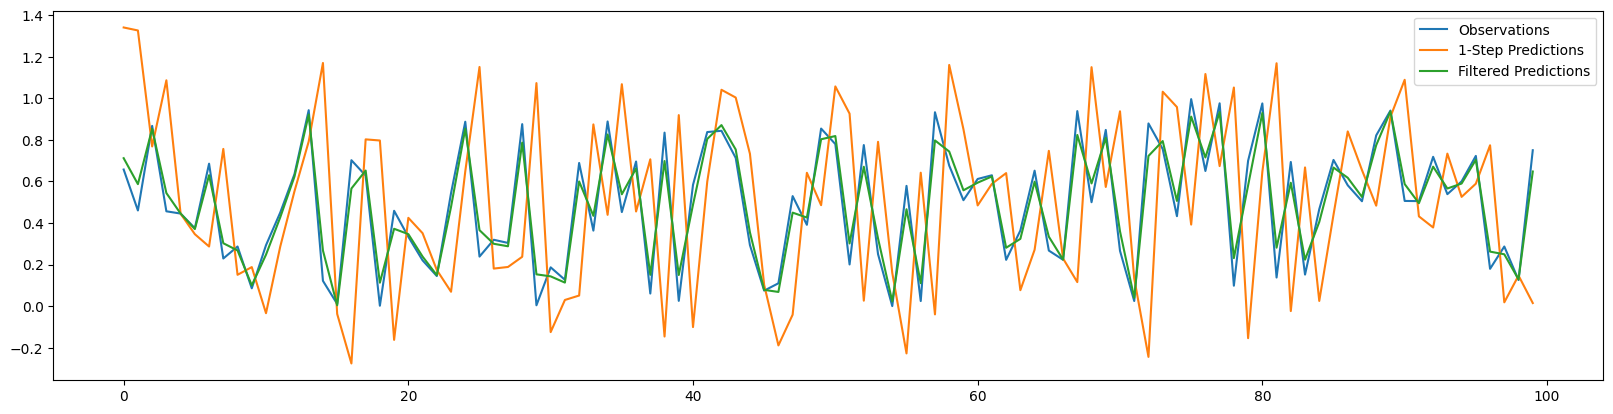

In [46]:
fig, ax = plt.subplots()
x_data = list(range(period))
y1_data = list(model_extract(observed_spaces))
y2_data = list(model_extract(evolved_spaces))
y3_data = list(model_extract(filtered_spaces))
ax.plot(x_data, y1_data, label="Observations")
ax.plot(x_data, y2_data, label="1-Step Predictions")
ax.plot(x_data, y3_data, label="Filtered Predictions")
ax.legend()
fig.set_figwidth(20)
plt.show()